In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
import json
from PIL import Image as pil_image

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/VGG16DeepLab_Fiji256.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

c:\users\rechant\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
<class 'keras.engine.training.Model'>
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [2]:
# Test export of patches from gdal
imgpath = 'F:/Images/Fiji/mosaiced_001.TIF'
truthpath = 'F:/Images/Fiji/truth_classes_wcldMask_001.TIF'
output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
labelkey = json_data["L3_ClassDict"]

print(Fiji.consolclass_weights)
print(Fiji.consolclass_count)

with open("init_args - VGG16DeepLab_Fiji256.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 250*np.ones(num_channels)
pixel_std = 250*np.ones(num_channels)
# datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
#     image_resample=True, pixelwise_center=True,
#     pixel_mean=pixel_mean, pixelwise_std_normalization=True,
#     pixel_std=pixel_std)

# train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
#     target_size=(y,x),
#     color_mode='8channel',
#     passedclasses = labelkey,
#     class_mode = 'categorical',
#     batch_size = 6,
#     shuffle=True)

./utils\loadcoraldata_utils.py:205: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


{'Reef Crest - coralline algae ridge': 122.51391227369773, 'Fore-reef deep slope': 0, 'Fore-reef shallow slope': 115.12512946818141, 'Fore-reef shallow terrace': 108.58774298263833, 'Fore-reef octocorals-dominated (Caribbean)': 0, 'Back-reef pavement': 24.091198518651257, 'Back-reef coral framework': 1619.1200321156161, 'Back-reef coral bommies': 4608.650995755795, 'Back-reef octocorals-dominated (Caribbean)': 0, 'Lagoon Pinnacle reefs': 0, 'Lagoon Patch reefs': 0, 'Lagoon Fringing reefs': 0, 'Lagoon Deep water': 5923.750734368443, 'Fore-reef sand flats': 1152.7272578801242, 'Back-reef sediment-dominated': 109.00868745994116, 'Lagoon sediment apron - Barren': 0, 'Terrestrial Vegetated': 3.9729867372422634, 'Terrestrial Mangroves': 0, 'Intertidal Wetlands': 0, 'Beach (sand)': 422.03082350479093, 'Beach (rock)': 0, 'Seagrass Meadows': 76.70712960220835, 'Deep Ocean Water': 2.0189118100558163, 'Other': 6.290627915386691}
{'Reef Crest - coralline algae ridge': 230444, 'Fore-reef deep slope

(5012, 5633, 8)
(1024, 1024)
[ 1  3  4  6  7  8 14 15 17 20 22 23 24]


<IPython.core.display.Javascript object>


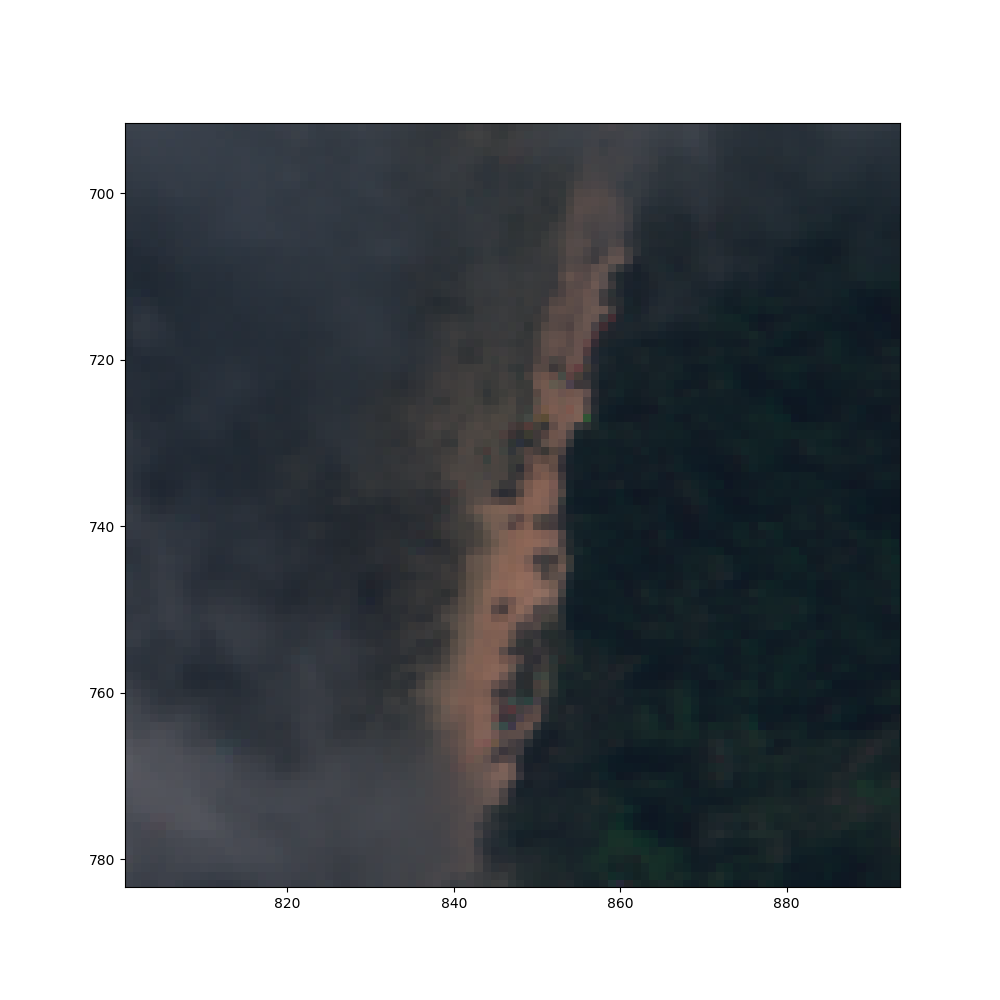

In [3]:
xstart = 500
xlen = 1024
# xlen = 3840
ystart = 1100
ylen = 1024
# ylen = 3200

predict_size = x

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = Fiji.truthimage_consolidated[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

print(Fiji.image.shape)
max_R = np.max(Fiji.testimage[:,:,4])
max_G = np.max(Fiji.testimage[:,:,2])
max_B = np.max(Fiji.testimage[:,:,1])
Fiji_RGB = np.rollaxis(np.asarray([1/max_R*Fiji.testimage[:,:,4], 1/max_G*Fiji.testimage[:,:,2], 1/max_B*Fiji.testimage[:,:,1]]),0,3)
print(Testtruth.shape)
print(np.unique(Testtruth))

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB)
plt.show()

In [8]:
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

Fiji.set_depth(500)
class_dict_min = np.min([Fiji.consolidated_class_dict[k] for k in Fiji.consolidated_class_dict])
print("Total Lines: ", Testtruth.shape[0])
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = x, num_classes = len(class_indices_rev), spacing = (64,64), predict_size = predict_size, num_lines=None, lastchannelremove=False)
# for i in range(whole_predict.shape[0]):
#     for j in range(whole_predict.shape[1]):
#         whole_predict[i,j] = train_generator.class_indices[class_indices_rev[whole_predict[i,j]]]

accuracy_new = 100*np.asarray((whole_predict+class_dict_min == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print(accuracy_new)
# print(accuracy)

{1: 'Reef Crest - coralline algae ridge', 2: 'Fore-reef deep slope', 3: 'Fore-reef shallow slope', 4: 'Fore-reef shallow terrace', 5: 'Fore-reef octocorals-dominated (Caribbean)', 6: 'Back-reef pavement', 7: 'Back-reef coral framework', 8: 'Back-reef coral bommies', 9: 'Back-reef octocorals-dominated (Caribbean)', 10: 'Lagoon Pinnacle reefs', 11: 'Lagoon Patch reefs', 12: 'Lagoon Fringing reefs', 13: 'Lagoon Deep water', 14: 'Fore-reef sand flats', 15: 'Back-reef sediment-dominated', 16: 'Lagoon sediment apron - Barren', 17: 'Terrestrial Vegetated', 18: 'Terrestrial Mangroves', 19: 'Intertidal Wetlands', 20: 'Beach (sand)', 21: 'Beach (rock)', 22: 'Seagrass Meadows', 23: 'Deep Ocean Water', 24: 'Other'}
Total Lines:  1024
82.041263580322278/ 769 completed


<IPython.core.display.Javascript object>


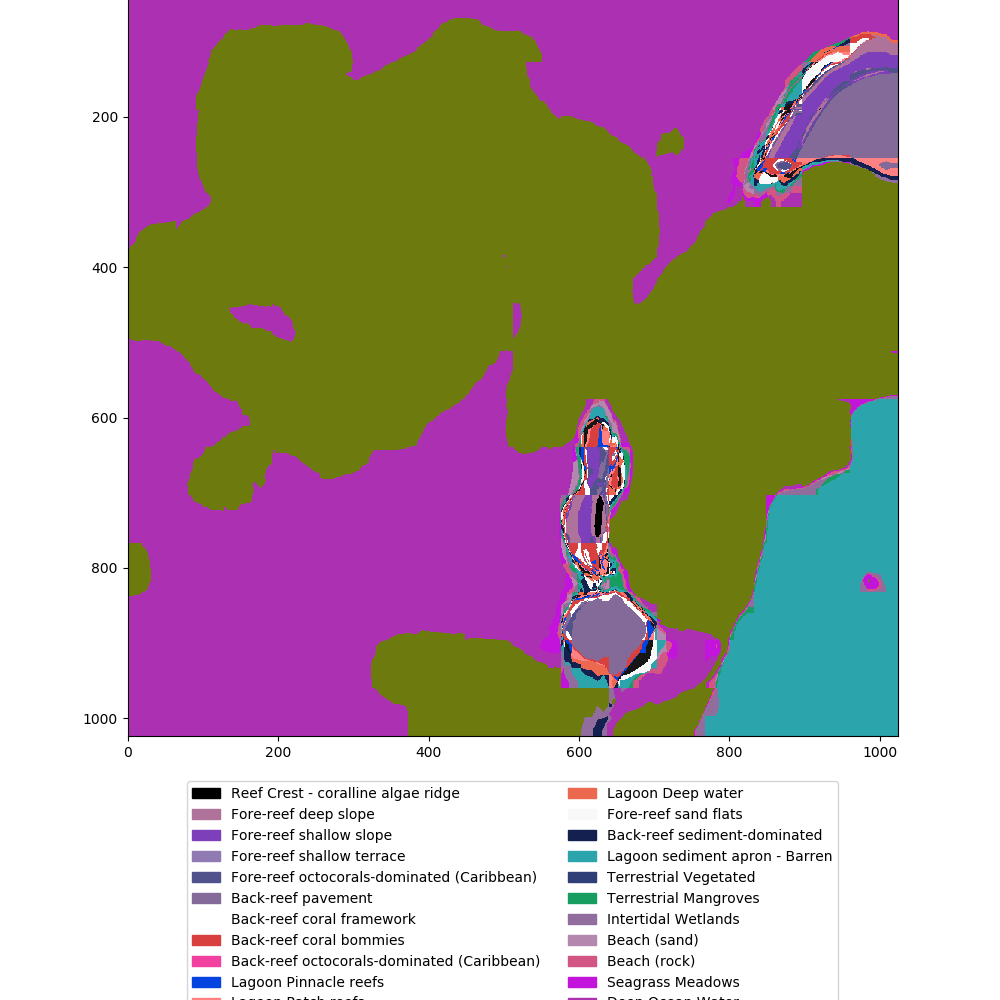

<IPython.core.display.Javascript object>


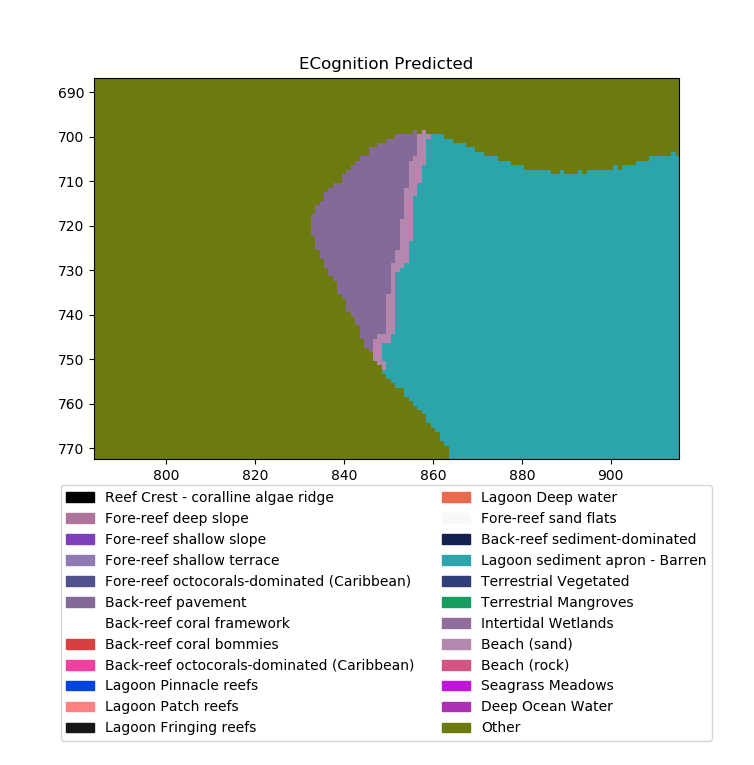

In [12]:
cmap = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:white', '#d83f3f', '#f140a0', 'xkcd:blue', '#ff8181',
                             '#161616', '#ec684e', '#f8f8f8', '#142050', '#2ca4ab',
                             '#303e77', '#189d60', '#916d9e', '#b487af',
                             '#d35583', '#c214db', '#ab31b2', 'xkcd:murky green'])
bounds = [i-0.5 for i in range(25)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

fig = plt.figure(2,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(whole_predict.astype(int), interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)], ['{}'.format(class_indices_rev[k]) for k in class_indices_rev], loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
# fig.savefig('Hyperopt_Visualize.png', bbox_inches='tight')


fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth-1, interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
              ['{}'.format(class_indices_rev[k]) for k in class_indices_rev],
              loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
ax.set_title('ECognition Predicted')
# ax.set_axis_off()
# fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
plt.show()

In [7]:
print(np.min([Fiji.consolidated_class_dict[k] for k in Fiji.consolidated_class_dict]))

1
